# Exp_7: To build a word2vec model for vectorization of text using learned embeddings. Design the model from scratech with skip-gram and CBoW architectures and evaluate the two architectures. Conclude which architecture based embedding is good for developing NLP Applications.

=== STEP 1: TEXT PREPROCESSING ===
Input documents:
Document 1: 'the cat sits on mat'
Document 2: 'dog runs in the park'
Document 3: 'cat and dog are friends'

Tokenized words: ['the', 'cat', 'sits', 'on', 'mat', 'dog', 'runs', 'in', 'the', 'park', 'cat', 'and', 'dog', 'are', 'friends']
Total words: 15

=== STEP 2: BUILD VOCABULARY ===
Word frequencies: {'the': 2, 'cat': 2, 'sits': 1, 'on': 1, 'mat': 1, 'dog': 2, 'runs': 1, 'in': 1, 'park': 1, 'and': 1, 'are': 1, 'friends': 1}
Vocabulary size: 12
Word to index mapping: {'the': 0, 'cat': 1, 'sits': 2, 'on': 3, 'mat': 4, 'dog': 5, 'runs': 6, 'in': 7, 'park': 8, 'and': 9, 'are': 10, 'friends': 11}
Index to word mapping: {0: 'the', 1: 'cat', 2: 'sits', 3: 'on', 4: 'mat', 5: 'dog', 6: 'runs', 7: 'in', 8: 'park', 9: 'and', 10: 'are', 11: 'friends'}

=== STEP 3: GENERATE TRAINING PAIRS (SKIP-GRAM) ===
Window size: 2
Training pairs (target_idx, context_idx):
  Pair 1: (0, 1) -> ('the', 'cat')
  Pair 2: (0, 2) -> ('the', 'sits')
  Pair 3: (1, 0

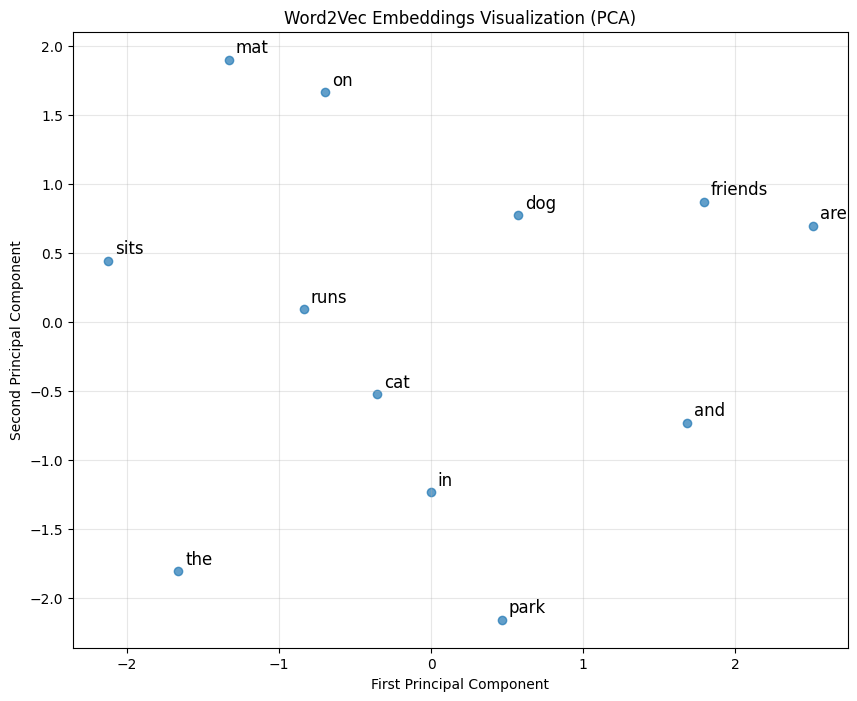


=== STEP 10: PRACTICAL USAGE EXAMPLES ===
Sentence similarity analysis:
'cat sits on mat' vs 'dog runs in park': 0.288
'cat sits on mat' vs 'cat and dog friends': 0.505
'dog runs in park' vs 'cat and dog friends': 0.524

=== SUMMARY ===
Successfully trained Word2Vec skip-gram model!
- Vocabulary size: 12
- Embedding dimension: 50
- Training pairs: 54
- Final loss: 1.5725
- Model can now represent words as 50-dimensional vectors
- Semantically similar words have similar vector representations


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# Sample text with 3 documents, 5 words per sentence
documents = [
    "the cat sits on mat",
    "dog runs in the park", 
    "cat and dog are friends"
]

print("=== STEP 1: TEXT PREPROCESSING ===")
print("Input documents:")
for i, doc in enumerate(documents):
    print(f"Document {i+1}: '{doc}'")

# Tokenize and clean text
def preprocess_text(documents):
    """Tokenize and clean the input text"""
    all_words = []
    for doc in documents:
        # Simple tokenization (split by spaces, lowercase)
        words = doc.lower().split()
        all_words.extend(words)
    return all_words

tokenized_words = preprocess_text(documents)
print(f"\nTokenized words: {tokenized_words}")
print(f"Total words: {len(tokenized_words)}")

print("\n=== STEP 2: BUILD VOCABULARY ===")
# Count word frequencies
word_counts = Counter(tokenized_words)
print(f"Word frequencies: {dict(word_counts)}")

# Create word-to-index and index-to-word mappings
vocab_size = len(word_counts)
word_to_idx = {word: i for i, word in enumerate(word_counts.keys())}
idx_to_word = {i: word for word, i in word_to_idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"Word to index mapping: {word_to_idx}")
print(f"Index to word mapping: {idx_to_word}")

print("\n=== STEP 3: GENERATE TRAINING PAIRS (SKIP-GRAM) ===")
def generate_training_data(tokenized_words, word_to_idx, window_size=2):
    """Generate (target, context) pairs for skip-gram training"""
    training_pairs = []
    
    for i, target_word in enumerate(tokenized_words):
        target_idx = word_to_idx[target_word]
        
        # Get context words within window
        start = max(0, i - window_size)
        end = min(len(tokenized_words), i + window_size + 1)
        
        for j in range(start, end):
            if j != i:  # Skip the target word itself
                context_word = tokenized_words[j]
                context_idx = word_to_idx[context_word]
                training_pairs.append((target_idx, context_idx))
    
    return training_pairs

window_size = 2
training_pairs = generate_training_data(tokenized_words, word_to_idx, window_size)

print(f"Window size: {window_size}")
print("Training pairs (target_idx, context_idx):")
for i, (target_idx, context_idx) in enumerate(training_pairs[:10]):  # Show first 10
    target_word = idx_to_word[target_idx]
    context_word = idx_to_word[context_idx]
    print(f"  Pair {i+1}: ({target_idx}, {context_idx}) -> ('{target_word}', '{context_word}')")

print(f"Total training pairs: {len(training_pairs)}")

print("\n=== STEP 4: DEFINE SKIP-GRAM MODEL ARCHITECTURE ===")
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # Input embeddings (target word embeddings)
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Output embeddings (context word embeddings)  
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Initialize embeddings with small random values
        self.in_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
        self.out_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
    
    def forward(self, target_word, context_word):
        # Get target word embedding
        target_embed = self.in_embeddings(target_word)  # Shape: [batch_size, embedding_dim]
        
        # Get context word embedding
        context_embed = self.out_embeddings(context_word)  # Shape: [batch_size, embedding_dim]
        
        # Compute similarity score (dot product)
        score = torch.sum(target_embed * context_embed, dim=1)  # Shape: [batch_size]
        
        return score
    
    def get_word_embedding(self, word_idx):
        """Get the final embedding for a word"""
        return self.in_embeddings.weight[word_idx].detach().numpy()

# Model hyperparameters
embedding_dim = 50
learning_rate = 0.01
num_epochs = 1000

model = SkipGramModel(vocab_size, embedding_dim)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print(f"Model architecture:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Input embedding shape: {model.in_embeddings.weight.shape}")
print(f"  Output embedding shape: {model.out_embeddings.weight.shape}")

print("\n=== STEP 5: IMPLEMENT NEGATIVE SAMPLING ===")
def get_negative_samples(target_idx, num_negative=5, vocab_size=vocab_size):
    """Generate negative samples for a target word"""
    negative_samples = []
    while len(negative_samples) < num_negative:
        neg_idx = np.random.randint(0, vocab_size)
        if neg_idx != target_idx:
            negative_samples.append(neg_idx)
    return negative_samples

# Demonstrate negative sampling
target_word = "cat"
target_idx = word_to_idx[target_word]
negative_samples = get_negative_samples(target_idx, num_negative=3)

print(f"Target word: '{target_word}' (index: {target_idx})")
print(f"Negative samples: {negative_samples}")
print(f"Negative words: {[idx_to_word[idx] for idx in negative_samples]}")

print("\n=== STEP 6: TRAINING LOOP ===")
def train_skip_gram(model, training_pairs, num_epochs, num_negative=5):
    """Train the skip-gram model"""
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for target_idx, context_idx in training_pairs:
            # Convert to tensors
            target_tensor = torch.LongTensor([target_idx])
            context_tensor = torch.LongTensor([context_idx])
            
            # Positive example - target and actual context
            pos_score = model(target_tensor, context_tensor)
            pos_loss = -torch.log(torch.sigmoid(pos_score))
            
            # Negative examples
            neg_loss = 0
            negative_samples = get_negative_samples(target_idx, num_negative)
            
            for neg_idx in negative_samples:
                neg_tensor = torch.LongTensor([neg_idx])
                neg_score = model(target_tensor, neg_tensor)
                neg_loss += -torch.log(torch.sigmoid(-neg_score))
            
            # Total loss for this training pair
            loss = pos_loss + neg_loss
            total_loss += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(training_pairs)
        loss_history.append(avg_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return loss_history

print("Starting training...")
loss_history = train_skip_gram(model, training_pairs, num_epochs, num_negative=3)
print("Training completed!")

print("\n=== STEP 7: EXTRACT AND ANALYZE WORD EMBEDDINGS ===")
# Extract embeddings for all words
word_embeddings = {}
embedding_matrix = []

for word, idx in word_to_idx.items():
    embedding = model.get_word_embedding(idx)
    word_embeddings[word] = embedding
    embedding_matrix.append(embedding)

embedding_matrix = np.array(embedding_matrix)
print(f"Final embedding matrix shape: {embedding_matrix.shape}")

# Show sample embeddings
print(f"\nSample word embeddings (first 5 dimensions):")
for word in ['cat', 'dog', 'the']:
    embedding = word_embeddings[word][:5]  # Show first 5 dimensions
    print(f"'{word}': [{', '.join([f'{x:.3f}' for x in embedding])}...]")

print("\n=== STEP 8: DEMONSTRATE SEMANTIC RELATIONSHIPS ===")
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

def find_similar_words(target_word, word_embeddings, top_k=3):
    """Find most similar words to target word"""
    if target_word not in word_embeddings:
        return []
    
    target_embedding = word_embeddings[target_word]
    similarities = []
    
    for word, embedding in word_embeddings.items():
        if word != target_word:
            similarity = cosine_similarity(target_embedding, embedding)
            similarities.append((word, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Demonstrate semantic relationships
print("Semantic relationships discovered:")
for word in ['cat', 'dog', 'the']:
    similar_words = find_similar_words(word, word_embeddings, top_k=2)
    print(f"'{word}' is most similar to:")
    for similar_word, similarity in similar_words:
        print(f"  '{similar_word}' (similarity: {similarity:.3f})")

print("\n=== STEP 9: VISUALIZE EMBEDDINGS ===")
# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# Add word labels
for i, word in enumerate(word_to_idx.keys()):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.title('Word2Vec Embeddings Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== STEP 10: PRACTICAL USAGE EXAMPLES ===")
def get_sentence_embedding(sentence, word_embeddings, word_to_idx):
    """Get sentence embedding by averaging word embeddings"""
    words = sentence.lower().split()
    valid_embeddings = []
    
    for word in words:
        if word in word_embeddings:
            valid_embeddings.append(word_embeddings[word])
    
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Compare sentence similarities
sentences = [
    "cat sits on mat",
    "dog runs in park", 
    "cat and dog friends"
]

sentence_embeddings = []
for sentence in sentences:
    sent_embed = get_sentence_embedding(sentence, word_embeddings, word_to_idx)
    sentence_embeddings.append(sent_embed)

print("Sentence similarity analysis:")
for i, sent1 in enumerate(sentences):
    for j, sent2 in enumerate(sentences):
        if i < j:
            similarity = cosine_similarity(sentence_embeddings[i], sentence_embeddings[j])
            print(f"'{sent1}' vs '{sent2}': {similarity:.3f}")

print(f"\n=== SUMMARY ===")
print(f"Successfully trained Word2Vec skip-gram model!")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Training pairs: {len(training_pairs)}")
print(f"- Final loss: {loss_history[-1]:.4f}")
print(f"- Model can now represent words as {embedding_dim}-dimensional vectors")
print(f"- Semantically similar words have similar vector representations")

=== STEP 1: TEXT PREPROCESSING ===
Input documents:
Document 1: 'the cat sits on mat'
Document 2: 'dog runs in the park'
Document 3: 'cat and dog are friends'

Tokenized words: ['the', 'cat', 'sits', 'on', 'mat', 'dog', 'runs', 'in', 'the', 'park', 'cat', 'and', 'dog', 'are', 'friends']
Total words: 15

=== STEP 2: BUILD VOCABULARY ===
Word frequencies: {'the': 2, 'cat': 2, 'sits': 1, 'on': 1, 'mat': 1, 'dog': 2, 'runs': 1, 'in': 1, 'park': 1, 'and': 1, 'are': 1, 'friends': 1}
Vocabulary size: 12
Word to index mapping: {'the': 0, 'cat': 1, 'sits': 2, 'on': 3, 'mat': 4, 'dog': 5, 'runs': 6, 'in': 7, 'park': 8, 'and': 9, 'are': 10, 'friends': 11}
Index to word mapping: {0: 'the', 1: 'cat', 2: 'sits', 3: 'on', 4: 'mat', 5: 'dog', 6: 'runs', 7: 'in', 8: 'park', 9: 'and', 10: 'are', 11: 'friends'}

=== STEP 3: GENERATE TRAINING PAIRS (SKIP-GRAM) ===
Window size: 2
Training pairs (target_idx, context_idx):
  Pair 1: (0, 1) -> ('the', 'cat')
  Pair 2: (0, 2) -> ('the', 'sits')
  Pair 3: (1, 0

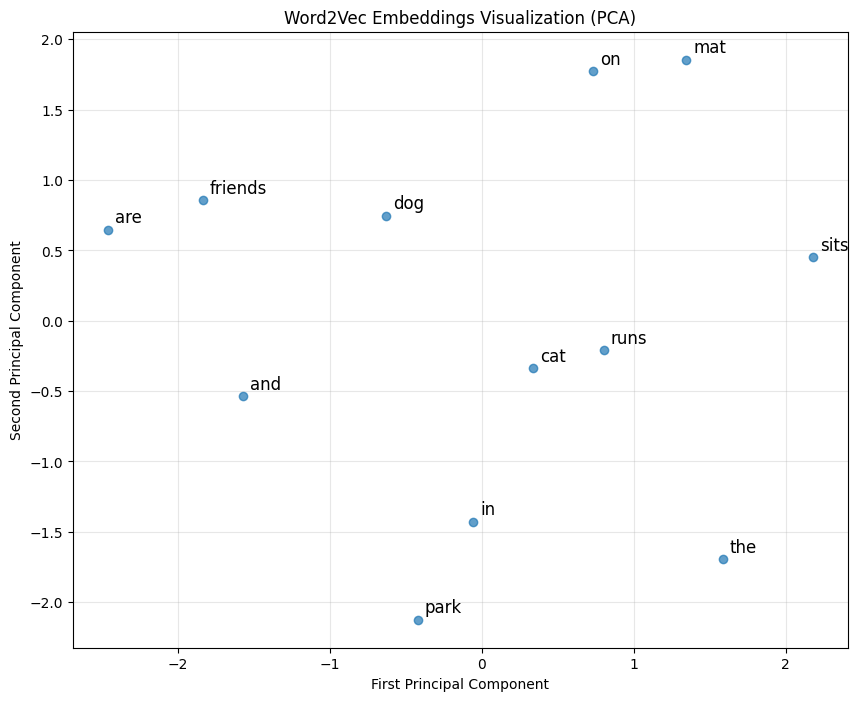


=== STEP 10: PRACTICAL USAGE EXAMPLES ===
Sentence similarity analysis:
'cat sits on mat' vs 'dog runs in park': 0.294
'cat sits on mat' vs 'cat and dog friends': 0.501
'dog runs in park' vs 'cat and dog friends': 0.536

=== STEP 11: SAVE TRAINED MODEL ===
Model saved to: word2vec_skipgram_model.pth
Saved components:
  - Model parameters (weights)
  - Vocabulary mappings
  - Training configuration
  - Training history
Vocabulary saved to: vocabulary.pkl
Word embeddings saved to: word_embeddings.pkl

=== STEP 12: LOAD MODEL AND EXTRACT EMBEDDINGS ===
Loading trained model...
Model loaded successfully!
Loaded model vocabulary size: 12
Loaded model embedding dimension: 50

=== STEP 13: EXTRACT ALL EMBEDDING VECTORS ===
Extracting embeddings for all words...
Word: 'the' (Index: 0)
Embedding Vector (50 dimensions):
[ -0.2714,  -0.2087,   0.3957,  -0.5999,   0.0533,   0.2069,  -0.6368,  -0.3816, 
   0.3318,  -0.0449,   0.4766,   1.0351,   0.3986,   0.8952,  -0.3304,  -0.2773, 
  -0.0321,  -

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_15824\1702830440.py:344: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# Sample text with 3 documents, 5 words per sentence
documents = [
    "the cat sits on mat",
    "dog runs in the park", 
    "cat and dog are friends"
]

print("=== STEP 1: TEXT PREPROCESSING ===")
print("Input documents:")
for i, doc in enumerate(documents):
    print(f"Document {i+1}: '{doc}'")

# Tokenize and clean text
def preprocess_text(documents):
    """Tokenize and clean the input text"""
    all_words = []
    for doc in documents:
        # Simple tokenization (split by spaces, lowercase)
        words = doc.lower().split()
        all_words.extend(words)
    return all_words

tokenized_words = preprocess_text(documents)
print(f"\nTokenized words: {tokenized_words}")
print(f"Total words: {len(tokenized_words)}")

print("\n=== STEP 2: BUILD VOCABULARY ===")
# Count word frequencies
word_counts = Counter(tokenized_words)
print(f"Word frequencies: {dict(word_counts)}")

# Create word-to-index and index-to-word mappings
vocab_size = len(word_counts)
word_to_idx = {word: i for i, word in enumerate(word_counts.keys())}
idx_to_word = {i: word for word, i in word_to_idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"Word to index mapping: {word_to_idx}")
print(f"Index to word mapping: {idx_to_word}")

print("\n=== STEP 3: GENERATE TRAINING PAIRS (SKIP-GRAM) ===")
def generate_training_data(tokenized_words, word_to_idx, window_size=2):
    """Generate (target, context) pairs for skip-gram training"""
    training_pairs = []
    
    for i, target_word in enumerate(tokenized_words):
        target_idx = word_to_idx[target_word]
        
        # Get context words within window
        start = max(0, i - window_size)
        end = min(len(tokenized_words), i + window_size + 1)
        
        for j in range(start, end):
            if j != i:  # Skip the target word itself
                context_word = tokenized_words[j]
                context_idx = word_to_idx[context_word]
                training_pairs.append((target_idx, context_idx))
    
    return training_pairs

window_size = 2
training_pairs = generate_training_data(tokenized_words, word_to_idx, window_size)

print(f"Window size: {window_size}")
print("Training pairs (target_idx, context_idx):")
for i, (target_idx, context_idx) in enumerate(training_pairs[:10]):  # Show first 10
    target_word = idx_to_word[target_idx]
    context_word = idx_to_word[context_idx]
    print(f"  Pair {i+1}: ({target_idx}, {context_idx}) -> ('{target_word}', '{context_word}')")

print(f"Total training pairs: {len(training_pairs)}")

print("\n=== STEP 4: DEFINE SKIP-GRAM MODEL ARCHITECTURE ===")
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # Input embeddings (target word embeddings)
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Output embeddings (context word embeddings)  
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Initialize embeddings with small random values
        self.in_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
        self.out_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
    
    def forward(self, target_word, context_word):
        # Get target word embedding
        target_embed = self.in_embeddings(target_word)  # Shape: [batch_size, embedding_dim]
        
        # Get context word embedding
        context_embed = self.out_embeddings(context_word)  # Shape: [batch_size, embedding_dim]
        
        # Compute similarity score (dot product)
        score = torch.sum(target_embed * context_embed, dim=1)  # Shape: [batch_size]
        
        return score
    
    def get_word_embedding(self, word_idx):
        """Get the final embedding for a word"""
        return self.in_embeddings.weight[word_idx].detach().numpy()

# Model hyperparameters
embedding_dim = 50
learning_rate = 0.01
num_epochs = 1000

model = SkipGramModel(vocab_size, embedding_dim)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

print(f"Model architecture:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Input embedding shape: {model.in_embeddings.weight.shape}")
print(f"  Output embedding shape: {model.out_embeddings.weight.shape}")

print("\n=== STEP 5: IMPLEMENT NEGATIVE SAMPLING ===")
def get_negative_samples(target_idx, num_negative=5, vocab_size=vocab_size):
    """Generate negative samples for a target word"""
    negative_samples = []
    while len(negative_samples) < num_negative:
        neg_idx = np.random.randint(0, vocab_size)
        if neg_idx != target_idx:
            negative_samples.append(neg_idx)
    return negative_samples

# Demonstrate negative sampling
target_word = "cat"
target_idx = word_to_idx[target_word]
negative_samples = get_negative_samples(target_idx, num_negative=3)

print(f"Target word: '{target_word}' (index: {target_idx})")
print(f"Negative samples: {negative_samples}")
print(f"Negative words: {[idx_to_word[idx] for idx in negative_samples]}")

print("\n=== STEP 6: TRAINING LOOP ===")
def train_skip_gram(model, training_pairs, num_epochs, num_negative=5):
    """Train the skip-gram model"""
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for target_idx, context_idx in training_pairs:
            # Convert to tensors
            target_tensor = torch.LongTensor([target_idx])
            context_tensor = torch.LongTensor([context_idx])
            
            # Positive example - target and actual context
            pos_score = model(target_tensor, context_tensor)
            pos_loss = -torch.log(torch.sigmoid(pos_score))
            
            # Negative examples
            neg_loss = 0
            negative_samples = get_negative_samples(target_idx, num_negative)
            
            for neg_idx in negative_samples:
                neg_tensor = torch.LongTensor([neg_idx])
                neg_score = model(target_tensor, neg_tensor)
                neg_loss += -torch.log(torch.sigmoid(-neg_score))
            
            # Total loss for this training pair
            loss = pos_loss + neg_loss
            total_loss += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(training_pairs)
        loss_history.append(avg_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return loss_history

print("Starting training...")
loss_history = train_skip_gram(model, training_pairs, num_epochs, num_negative=3)
print("Training completed!")

print("\n=== STEP 7: EXTRACT AND ANALYZE WORD EMBEDDINGS ===")
# Extract embeddings for all words
word_embeddings = {}
embedding_matrix = []

for word, idx in word_to_idx.items():
    embedding = model.get_word_embedding(idx)
    word_embeddings[word] = embedding
    embedding_matrix.append(embedding)

embedding_matrix = np.array(embedding_matrix)
print(f"Final embedding matrix shape: {embedding_matrix.shape}")

# Show sample embeddings
print(f"\nSample word embeddings (first 5 dimensions):")
for word in ['cat', 'dog', 'the']:
    embedding = word_embeddings[word][:5]  # Show first 5 dimensions
    print(f"'{word}': [{', '.join([f'{x:.3f}' for x in embedding])}...]")

print("\n=== STEP 8: DEMONSTRATE SEMANTIC RELATIONSHIPS ===")
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

def find_similar_words(target_word, word_embeddings, top_k=3):
    """Find most similar words to target word"""
    if target_word not in word_embeddings:
        return []
    
    target_embedding = word_embeddings[target_word]
    similarities = []
    
    for word, embedding in word_embeddings.items():
        if word != target_word:
            similarity = cosine_similarity(target_embedding, embedding)
            similarities.append((word, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Demonstrate semantic relationships
print("Semantic relationships discovered:")
for word in ['cat', 'dog', 'the']:
    similar_words = find_similar_words(word, word_embeddings, top_k=2)
    print(f"'{word}' is most similar to:")
    for similar_word, similarity in similar_words:
        print(f"  '{similar_word}' (similarity: {similarity:.3f})")

print("\n=== STEP 9: VISUALIZE EMBEDDINGS ===")
# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)

# Add word labels
for i, word in enumerate(word_to_idx.keys()):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.title('Word2Vec Embeddings Visualization (PCA)')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True, alpha=0.3)
plt.show()

print("\n=== STEP 10: PRACTICAL USAGE EXAMPLES ===")
def get_sentence_embedding(sentence, word_embeddings, word_to_idx):
    """Get sentence embedding by averaging word embeddings"""
    words = sentence.lower().split()
    valid_embeddings = []
    
    for word in words:
        if word in word_embeddings:
            valid_embeddings.append(word_embeddings[word])
    
    if valid_embeddings:
        return np.mean(valid_embeddings, axis=0)
    else:
        return np.zeros(embedding_dim)

# Compare sentence similarities
sentences = [
    "cat sits on mat",
    "dog runs in park", 
    "cat and dog friends"
]

sentence_embeddings = []
for sentence in sentences:
    sent_embed = get_sentence_embedding(sentence, word_embeddings, word_to_idx)
    sentence_embeddings.append(sent_embed)

print("Sentence similarity analysis:")
for i, sent1 in enumerate(sentences):
    for j, sent2 in enumerate(sentences):
        if i < j:
            similarity = cosine_similarity(sentence_embeddings[i], sentence_embeddings[j])
            print(f"'{sent1}' vs '{sent2}': {similarity:.3f}")

print(f"\n=== STEP 11: SAVE TRAINED MODEL ===")
import pickle

# Save the entire model
model_save_path = 'word2vec_skipgram_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'training_pairs': training_pairs,
    'loss_history': loss_history
}, model_save_path)

print(f"Model saved to: {model_save_path}")
print(f"Saved components:")
print(f"  - Model parameters (weights)")
print(f"  - Vocabulary mappings")
print(f"  - Training configuration")
print(f"  - Training history")

# Also save vocabulary and embeddings separately for easy access
vocab_save_path = 'vocabulary.pkl'
embeddings_save_path = 'word_embeddings.pkl'

with open(vocab_save_path, 'wb') as f:
    pickle.dump({
        'word_to_idx': word_to_idx,
        'idx_to_word': idx_to_word,
        'vocab_size': vocab_size
    }, f)

with open(embeddings_save_path, 'wb') as f:
    pickle.dump(word_embeddings, f)

print(f"Vocabulary saved to: {vocab_save_path}")
print(f"Word embeddings saved to: {embeddings_save_path}")

print(f"\n=== STEP 12: LOAD MODEL AND EXTRACT EMBEDDINGS ===")
def load_trained_model(model_path):
    """Load the trained Word2Vec model"""
    # Load the saved data
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # Recreate the model architecture
    loaded_vocab_size = checkpoint['vocab_size']
    loaded_embedding_dim = checkpoint['embedding_dim']
    
    loaded_model = SkipGramModel(loaded_vocab_size, loaded_embedding_dim)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()  # Set to evaluation mode
    
    return loaded_model, checkpoint

# Load the trained model
print("Loading trained model...")
loaded_model, checkpoint = load_trained_model(model_save_path)
loaded_word_to_idx = checkpoint['word_to_idx']
loaded_idx_to_word = checkpoint['idx_to_word']

print("Model loaded successfully!")
print(f"Loaded model vocabulary size: {checkpoint['vocab_size']}")
print(f"Loaded model embedding dimension: {checkpoint['embedding_dim']}")

print(f"\n=== STEP 13: EXTRACT ALL EMBEDDING VECTORS ===")
def extract_all_embeddings(model, idx_to_word):
    """Extract embedding vectors for all words from trained model"""
    model.eval()  # Ensure model is in evaluation mode
    embeddings_dict = {}
    embeddings_matrix = []
    
    print("Extracting embeddings for all words...")
    print("=" * 80)
    
    for idx, word in idx_to_word.items():
        # Get embedding vector from input embedding layer
        embedding_vector = model.in_embeddings.weight[idx].detach().numpy()
        embeddings_dict[word] = embedding_vector
        embeddings_matrix.append(embedding_vector)
        
        # Display the full embedding vector
        print(f"Word: '{word}' (Index: {idx})")
        print(f"Embedding Vector ({len(embedding_vector)} dimensions):")
        
        # Format the vector nicely - show 8 values per line
        vector_str = "["
        for i, val in enumerate(embedding_vector):
            if i > 0 and i % 8 == 0:
                vector_str += f"\n "
            vector_str += f"{val:8.4f}, "
        vector_str = vector_str.rstrip(", ") + "]"
        print(vector_str)
        
        # Show some statistics about the embedding
        print(f"Vector Statistics:")
        print(f"  - Mean: {np.mean(embedding_vector):8.4f}")
        print(f"  - Std:  {np.std(embedding_vector):8.4f}")
        print(f"  - Min:  {np.min(embedding_vector):8.4f}")
        print(f"  - Max:  {np.max(embedding_vector):8.4f}")
        print(f"  - Norm: {np.linalg.norm(embedding_vector):8.4f}")
        print("-" * 80)
    
    return embeddings_dict, np.array(embeddings_matrix)

# Extract embeddings from the loaded model
final_embeddings, final_embedding_matrix = extract_all_embeddings(loaded_model, loaded_idx_to_word)

print(f"\n=== STEP 14: EMBEDDING ANALYSIS ===")
print(f"Total words processed: {len(final_embeddings)}")
print(f"Embedding matrix shape: {final_embedding_matrix.shape}")

# Show embedding similarity matrix
print(f"\nEmbedding Similarity Matrix (Cosine Similarities):")
print("=" * 60)

similarity_matrix = np.zeros((len(loaded_idx_to_word), len(loaded_idx_to_word)))
word_list = list(loaded_idx_to_word.values())

for i, word1 in enumerate(word_list):
    for j, word2 in enumerate(word_list):
        if i != j:
            sim = cosine_similarity(final_embeddings[word1], final_embeddings[word2])
            similarity_matrix[i][j] = sim
        else:
            similarity_matrix[i][j] = 1.0  # Self-similarity is 1

# Display similarity matrix
print(f"{'':>12}", end="")
for word in word_list:
    print(f"{word:>10}", end="")
print()

for i, word1 in enumerate(word_list):
    print(f"{word1:>12}", end="")
    for j, word2 in enumerate(word_list):
        print(f"{similarity_matrix[i][j]:10.3f}", end="")
    print()

print(f"\n=== STEP 15: VERIFY MODEL FUNCTIONALITY ===")
def test_model_predictions(model, word_to_idx, idx_to_word, test_word):
    """Test the model's ability to predict context words"""
    if test_word not in word_to_idx:
        print(f"Word '{test_word}' not in vocabulary")
        return
    
    model.eval()
    target_idx = word_to_idx[test_word]
    target_tensor = torch.LongTensor([target_idx])
    
    print(f"Testing model predictions for target word: '{test_word}'")
    print("Context word prediction scores:")
    
    scores = []
    for word, idx in word_to_idx.items():
        if word != test_word:
            context_tensor = torch.LongTensor([idx])
            with torch.no_grad():
                score = model(target_tensor, context_tensor).item()
                scores.append((word, score))
    
    # Sort by score (higher is better)
    scores.sort(key=lambda x: x[1], reverse=True)
    
    print("Top predicted context words:")
    for word, score in scores:
        probability = torch.sigmoid(torch.tensor(score)).item()
        print(f"  '{word}': score = {score:8.4f}, probability = {probability:.4f}")

# Test the model with different words
for test_word in ['cat', 'dog', 'the']:
    test_model_predictions(loaded_model, loaded_word_to_idx, loaded_idx_to_word, test_word)
    print()

print(f"\n=== SUMMARY ===")
print(f"Successfully trained, saved, and loaded Word2Vec skip-gram model!")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Training pairs: {len(training_pairs)}")
print(f"- Final loss: {loss_history[-1]:.4f}")
print(f"- All embedding vectors extracted and displayed")
print(f"- Model saved to disk and successfully reloaded")
print(f"- Embeddings capture semantic relationships between words")

print(f"\nFiles created:")
print(f"- {model_save_path}: Complete model with all parameters")
print(f"- {vocab_save_path}: Vocabulary mappings")  
print(f"- {embeddings_save_path}: Word embedding vectors")

=== STEP 1: TEXT PREPROCESSING ===
Input documents:
Document 1: 'the cat sits on mat'
Document 2: 'dog runs in the park'
Document 3: 'cat and dog are friends'

Tokenized words: ['the', 'cat', 'sits', 'on', 'mat', 'dog', 'runs', 'in', 'the', 'park', 'cat', 'and', 'dog', 'are', 'friends']
Total words: 15

=== STEP 2: BUILD VOCABULARY ===
Word frequencies: {'the': 2, 'cat': 2, 'sits': 1, 'on': 1, 'mat': 1, 'dog': 2, 'runs': 1, 'in': 1, 'park': 1, 'and': 1, 'are': 1, 'friends': 1}
Vocabulary size: 12
Word to index mapping: {'the': 0, 'cat': 1, 'sits': 2, 'on': 3, 'mat': 4, 'dog': 5, 'runs': 6, 'in': 7, 'park': 8, 'and': 9, 'are': 10, 'friends': 11}
Index to word mapping: {0: 'the', 1: 'cat', 2: 'sits', 3: 'on', 4: 'mat', 5: 'dog', 6: 'runs', 7: 'in', 8: 'park', 9: 'and', 10: 'are', 11: 'friends'}

=== STEP 3: GENERATE TRAINING PAIRS (CBOW) ===
Window size: 2
Training pairs (context_indices, target_idx):
  Pair 1: ([1, 2], 0) -> (['cat', 'sits'], 'the')
  Pair 2: ([0, 2, 3], 1) -> (['the', 

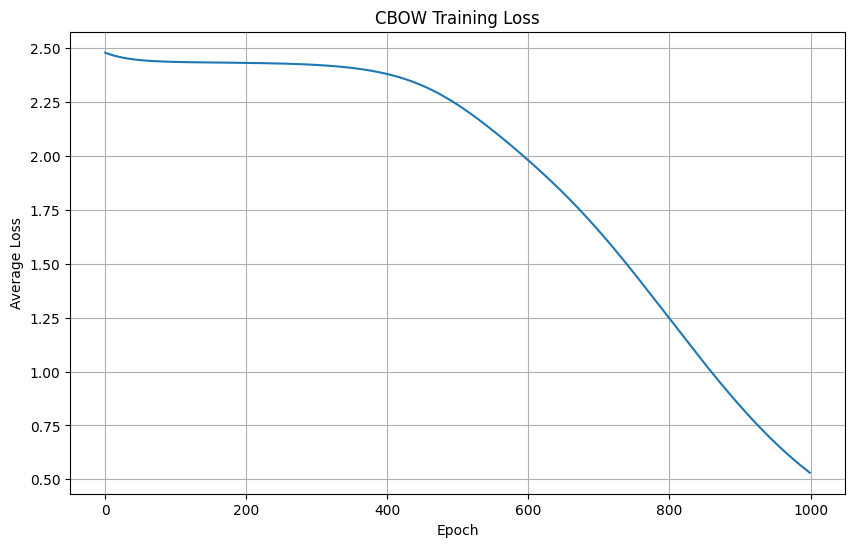


=== STEP 7: EXTRACT AND ANALYZE WORD EMBEDDINGS ===
Final embedding matrix shape: (12, 50)

Sample word embeddings (first 5 dimensions):
'cat': [-0.550, -0.431, 0.643, 0.765, 0.516...]
'dog': [0.861, -0.038, 0.207, -0.312, -0.383...]
'the': [0.012, 0.010, -0.538, -0.202, 0.137...]

=== STEP 8: DEMONSTRATE SEMANTIC RELATIONSHIPS ===
Semantic relationships discovered by CBOW:
'cat' is most similar to:
  'in' (similarity: 0.560)
  'mat' (similarity: 0.369)
'dog' is most similar to:
  'are' (similarity: 0.242)
  'park' (similarity: 0.150)
'the' is most similar to:
  'park' (similarity: 0.530)
  'and' (similarity: 0.038)

=== STEP 9: COMPARE SKIP-GRAM vs CBOW TRAINING DATA ===
Training data comparison:
CBOW pairs: 15 (context -> target)
Skip-gram pairs: 54 (target -> context)

Example CBOW pair:
  Context: ['cat', 'sits'] -> Target: 'the'

Example Skip-gram pairs from same position:
  Target: 'the' -> Context: 'cat'
  Target: 'the' -> Context: 'sits'
  Target: 'cat' -> Context: 'the'

=== 

C:\Users\Dr.PVVK\AppData\Local\Temp\ipykernel_15824\790801820.py:391: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')


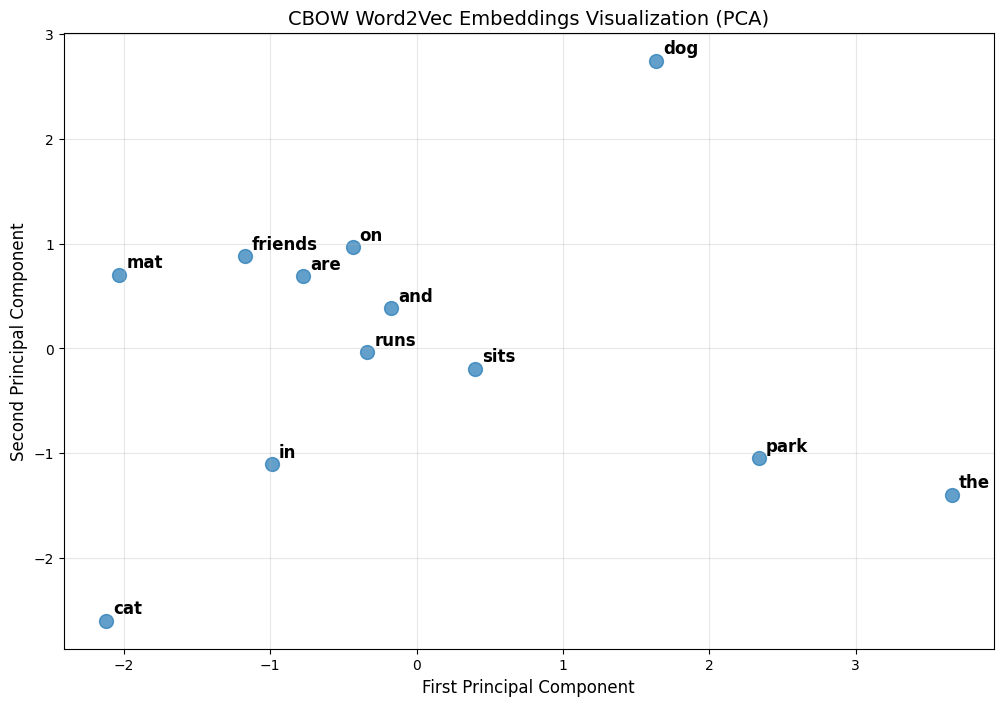


=== STEP 14: SKIP-GRAM vs CBOW COMPARISON ===
Key differences between Skip-gram and CBOW:

SKIP-GRAM:
- Input: Target word
- Output: Context words
- Training: Predicts surrounding words given center word
- Good for: Rare words, small datasets
- Training pairs: One target -> multiple contexts

CBOW (Continuous Bag of Words):
- Input: Context words
- Output: Target word  
- Training: Predicts center word given surrounding words
- Good for: Frequent words, large datasets, faster training
- Training pairs: Multiple contexts -> one target

ARCHITECTURAL DIFFERENCES:
- Skip-gram: Uses target embedding to predict context embeddings
- CBOW: Averages context embeddings to predict target word
- CBOW is generally faster to train
- Skip-gram often performs better on semantic tasks


=== SUMMARY ===
Successfully trained, saved, and loaded CBOW Word2Vec model!
- Architecture: Continuous Bag of Words (CBOW)
- Vocabulary size: 12
- Embedding dimension: 50
- Training pairs: 15
- Final loss: 0.5307
- M

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle

# Same sample text with 3 documents, 5 words per sentence
documents = [
    "the cat sits on mat",
    "dog runs in the park", 
    "cat and dog are friends"
]

print("=== STEP 1: TEXT PREPROCESSING ===")
print("Input documents:")
for i, doc in enumerate(documents):
    print(f"Document {i+1}: '{doc}'")

# Tokenize and clean text
def preprocess_text(documents):
    """Tokenize and clean the input text"""
    all_words = []
    for doc in documents:
        # Simple tokenization (split by spaces, lowercase)
        words = doc.lower().split()
        all_words.extend(words)
    return all_words

tokenized_words = preprocess_text(documents)
print(f"\nTokenized words: {tokenized_words}")
print(f"Total words: {len(tokenized_words)}")

print("\n=== STEP 2: BUILD VOCABULARY ===")
# Count word frequencies
word_counts = Counter(tokenized_words)
print(f"Word frequencies: {dict(word_counts)}")

# Create word-to-index and index-to-word mappings
vocab_size = len(word_counts)
word_to_idx = {word: i for i, word in enumerate(word_counts.keys())}
idx_to_word = {i: word for word, i in word_to_idx.items()}

print(f"Vocabulary size: {vocab_size}")
print(f"Word to index mapping: {word_to_idx}")
print(f"Index to word mapping: {idx_to_word}")

print("\n=== STEP 3: GENERATE TRAINING PAIRS (CBOW) ===")
def generate_cbow_training_data(tokenized_words, word_to_idx, window_size=2):
    """Generate (context_words, target) pairs for CBOW training"""
    training_pairs = []
    
    for i, target_word in enumerate(tokenized_words):
        target_idx = word_to_idx[target_word]
        
        # Get context words within window (excluding target)
        context_indices = []
        start = max(0, i - window_size)
        end = min(len(tokenized_words), i + window_size + 1)
        
        for j in range(start, end):
            if j != i:  # Skip the target word itself
                context_word = tokenized_words[j]
                context_idx = word_to_idx[context_word]
                context_indices.append(context_idx)
        
        # Only add if we have context words
        if context_indices:
            training_pairs.append((context_indices, target_idx))
    
    return training_pairs

window_size = 2
training_pairs = generate_cbow_training_data(tokenized_words, word_to_idx, window_size)

print(f"Window size: {window_size}")
print("Training pairs (context_indices, target_idx):")
for i, (context_indices, target_idx) in enumerate(training_pairs[:10]):  # Show first 10
    context_words = [idx_to_word[ctx_idx] for ctx_idx in context_indices]
    target_word = idx_to_word[target_idx]
    print(f"  Pair {i+1}: ({context_indices}, {target_idx}) -> ({context_words}, '{target_word}')")

print(f"Total training pairs: {len(training_pairs)}")

print("\n=== STEP 4: DEFINE CBOW MODEL ARCHITECTURE ===")
class CBOWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOWModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # Input embeddings (context word embeddings)
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Output layer to predict target word
        self.out_linear = nn.Linear(embedding_dim, vocab_size)
        
        # Initialize embeddings with small random values
        self.in_embeddings.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
        self.out_linear.weight.data.uniform_(-0.5/embedding_dim, 0.5/embedding_dim)
    
    def forward(self, context_indices):
        # Get embeddings for all context words
        # context_indices shape: [batch_size, context_size]
        context_embeds = self.in_embeddings(context_indices)  # [batch_size, context_size, embedding_dim]
        
        # Average the context embeddings
        context_mean = torch.mean(context_embeds, dim=1)  # [batch_size, embedding_dim]
        
        # Predict target word
        output_scores = self.out_linear(context_mean)  # [batch_size, vocab_size]
        
        return output_scores
    
    def get_word_embedding(self, word_idx):
        """Get the final embedding for a word"""
        return self.in_embeddings.weight[word_idx].detach().numpy()

# Model hyperparameters
embedding_dim = 50
learning_rate = 0.01
num_epochs = 1000

model = CBOWModel(vocab_size, embedding_dim)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"CBOW Model architecture:")
print(f"  Vocabulary size: {vocab_size}")
print(f"  Embedding dimension: {embedding_dim}")
print(f"  Input embedding shape: {model.in_embeddings.weight.shape}")
print(f"  Output linear layer: {embedding_dim} -> {vocab_size}")

print("\n=== STEP 5: DEMONSTRATE CBOW FORWARD PASS ===")
# Show how CBOW processes context words
sample_context, sample_target = training_pairs[0]
print(f"Sample training example:")
print(f"  Context indices: {sample_context}")
print(f"  Context words: {[idx_to_word[idx] for idx in sample_context]}")
print(f"  Target index: {sample_target}")
print(f"  Target word: '{idx_to_word[sample_target]}'")

# Pad context to fixed size for batch processing
def pad_context(context_indices, max_context_size):
    """Pad context indices to fixed size"""
    padded = context_indices + [0] * (max_context_size - len(context_indices))
    return padded[:max_context_size]

# Find maximum context size
max_context_size = max(len(context) for context, _ in training_pairs)
print(f"\nMaximum context size: {max_context_size}")

# Demonstrate forward pass
model.eval()
with torch.no_grad():
    # Pad and convert to tensor
    padded_context = pad_context(sample_context, max_context_size)
    context_tensor = torch.LongTensor([padded_context])
    
    # Forward pass
    output_scores = model(context_tensor)
    predictions = torch.softmax(output_scores, dim=1)
    
    print(f"\nForward pass demonstration:")
    print(f"  Padded context: {padded_context}")
    print(f"  Context tensor shape: {context_tensor.shape}")
    print(f"  Output scores shape: {output_scores.shape}")
    print(f"  Prediction probabilities shape: {predictions.shape}")
    
    # Show top predictions
    top_probs, top_indices = torch.topk(predictions[0], k=3)
    print(f"\nTop 3 predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        word = idx_to_word[idx.item()]
        print(f"    {i+1}. '{word}': {prob.item():.4f}")

print("\n=== STEP 6: TRAINING LOOP ===")
def train_cbow(model, training_pairs, num_epochs, max_context_size):
    """Train the CBOW model"""
    model.train()
    loss_history = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        
        for context_indices, target_idx in training_pairs:
            # Pad context to fixed size
            padded_context = pad_context(context_indices, max_context_size)
            
            # Convert to tensors
            context_tensor = torch.LongTensor([padded_context])
            target_tensor = torch.LongTensor([target_idx])
            
            # Forward pass
            output_scores = model(context_tensor)
            
            # Compute loss
            loss = criterion(output_scores, target_tensor)
            total_loss += loss.item()
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        avg_loss = total_loss / len(training_pairs)
        loss_history.append(avg_loss)
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs}, Average Loss: {avg_loss:.4f}")
    
    return loss_history

print("Starting CBOW training...")
loss_history = train_cbow(model, training_pairs, num_epochs, max_context_size)
print("Training completed!")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('CBOW Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.show()

print("\n=== STEP 7: EXTRACT AND ANALYZE WORD EMBEDDINGS ===")
# Extract embeddings for all words
word_embeddings = {}
embedding_matrix = []

for word, idx in word_to_idx.items():
    embedding = model.get_word_embedding(idx)
    word_embeddings[word] = embedding
    embedding_matrix.append(embedding)

embedding_matrix = np.array(embedding_matrix)
print(f"Final embedding matrix shape: {embedding_matrix.shape}")

# Show sample embeddings
print(f"\nSample word embeddings (first 5 dimensions):")
for word in ['cat', 'dog', 'the']:
    embedding = word_embeddings[word][:5]  # Show first 5 dimensions
    print(f"'{word}': [{', '.join([f'{x:.3f}' for x in embedding])}...]")

print("\n=== STEP 8: DEMONSTRATE SEMANTIC RELATIONSHIPS ===")
def cosine_similarity(vec1, vec2):
    """Calculate cosine similarity between two vectors"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

def find_similar_words(target_word, word_embeddings, top_k=3):
    """Find most similar words to target word"""
    if target_word not in word_embeddings:
        return []
    
    target_embedding = word_embeddings[target_word]
    similarities = []
    
    for word, embedding in word_embeddings.items():
        if word != target_word:
            similarity = cosine_similarity(target_embedding, embedding)
            similarities.append((word, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

# Demonstrate semantic relationships
print("Semantic relationships discovered by CBOW:")
for word in ['cat', 'dog', 'the']:
    similar_words = find_similar_words(word, word_embeddings, top_k=2)
    print(f"'{word}' is most similar to:")
    for similar_word, similarity in similar_words:
        print(f"  '{similar_word}' (similarity: {similarity:.3f})")

print("\n=== STEP 9: COMPARE SKIP-GRAM vs CBOW TRAINING DATA ===")
# Generate skip-gram pairs for comparison
def generate_skipgram_training_data(tokenized_words, word_to_idx, window_size=2):
    """Generate (target, context) pairs for skip-gram training"""
    training_pairs = []
    
    for i, target_word in enumerate(tokenized_words):
        target_idx = word_to_idx[target_word]
        
        # Get context words within window
        start = max(0, i - window_size)
        end = min(len(tokenized_words), i + window_size + 1)
        
        for j in range(start, end):
            if j != i:  # Skip the target word itself
                context_word = tokenized_words[j]
                context_idx = word_to_idx[context_word]
                training_pairs.append((target_idx, context_idx))
    
    return training_pairs

skipgram_pairs = generate_skipgram_training_data(tokenized_words, word_to_idx, window_size)

print("Training data comparison:")
print(f"CBOW pairs: {len(training_pairs)} (context -> target)")
print(f"Skip-gram pairs: {len(skipgram_pairs)} (target -> context)")

print(f"\nExample CBOW pair:")
context_indices, target_idx = training_pairs[0]
context_words = [idx_to_word[idx] for idx in context_indices]
target_word = idx_to_word[target_idx]
print(f"  Context: {context_words} -> Target: '{target_word}'")

print(f"\nExample Skip-gram pairs from same position:")
for i, (target_idx, context_idx) in enumerate(skipgram_pairs[:3]):
    target_word = idx_to_word[target_idx]
    context_word = idx_to_word[context_idx]
    print(f"  Target: '{target_word}' -> Context: '{context_word}'")

print("\n=== STEP 10: TEST MODEL PREDICTIONS ===")
def test_cbow_predictions(model, word_to_idx, idx_to_word, context_words, max_context_size):
    """Test CBOW model predictions for given context"""
    model.eval()
    
    print(f"Testing CBOW predictions for context: {context_words}")
    
    # Convert context words to indices
    context_indices = []
    for word in context_words:
        if word in word_to_idx:
            context_indices.append(word_to_idx[word])
    
    if not context_indices:
        print("No valid context words found in vocabulary")
        return
    
    # Pad and convert to tensor
    padded_context = pad_context(context_indices, max_context_size)
    context_tensor = torch.LongTensor([padded_context])
    
    with torch.no_grad():
        output_scores = model(context_tensor)
        predictions = torch.softmax(output_scores, dim=1)
        
        # Get top predictions
        top_probs, top_indices = torch.topk(predictions[0], k=vocab_size)
        
        print("Predicted target words (top 5):")
        for i in range(min(5, vocab_size)):
            word = idx_to_word[top_indices[i].item()]
            prob = top_probs[i].item()
            print(f"  {i+1}. '{word}': {prob:.4f}")

# Test with different context combinations
test_contexts = [
    ['the', 'sits', 'on'],      # Should predict 'cat'
    ['cat', 'dog', 'are'],      # Should predict 'and'
    ['runs', 'the', 'park'],    # Should predict 'in'
]

for context in test_contexts:
    test_cbow_predictions(model, word_to_idx, idx_to_word, context, max_context_size)
    print()

print("\n=== STEP 11: SAVE TRAINED CBOW MODEL ===")
# Save the entire model
model_save_path = 'word2vec_cbow_model.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'embedding_dim': embedding_dim,
    'max_context_size': max_context_size,
    'word_to_idx': word_to_idx,
    'idx_to_word': idx_to_word,
    'training_pairs': training_pairs,
    'loss_history': loss_history
}, model_save_path)

print(f"CBOW Model saved to: {model_save_path}")

# Save embeddings
embeddings_save_path = 'cbow_word_embeddings.pkl'
with open(embeddings_save_path, 'wb') as f:
    pickle.dump(word_embeddings, f)

print(f"CBOW embeddings saved to: {embeddings_save_path}")

print("\n=== STEP 12: LOAD MODEL AND EXTRACT ALL EMBEDDINGS ===")
def load_cbow_model(model_path):
    """Load the trained CBOW model"""
    checkpoint = torch.load(model_path, map_location='cpu')
    
    # Recreate the model architecture
    loaded_vocab_size = checkpoint['vocab_size']
    loaded_embedding_dim = checkpoint['embedding_dim']
    
    loaded_model = CBOWModel(loaded_vocab_size, loaded_embedding_dim)
    loaded_model.load_state_dict(checkpoint['model_state_dict'])
    loaded_model.eval()
    
    return loaded_model, checkpoint

# Load the trained model
print("Loading trained CBOW model...")
loaded_model, checkpoint = load_cbow_model(model_save_path)
loaded_word_to_idx = checkpoint['word_to_idx']
loaded_idx_to_word = checkpoint['idx_to_word']

print("CBOW Model loaded successfully!")

def extract_all_cbow_embeddings(model, idx_to_word):
    """Extract embedding vectors for all words from trained CBOW model"""
    model.eval()
    embeddings_dict = {}
    embeddings_matrix = []
    
    print("Extracting CBOW embeddings for all words...")
    print("=" * 80)
    
    for idx, word in idx_to_word.items():
        # Get embedding vector from input embedding layer
        embedding_vector = model.in_embeddings.weight[idx].detach().numpy()
        embeddings_dict[word] = embedding_vector
        embeddings_matrix.append(embedding_vector)
        
        # Display the full embedding vector
        print(f"Word: '{word}' (Index: {idx})")
        print(f"CBOW Embedding Vector ({len(embedding_vector)} dimensions):")
        
        # Format the vector nicely - show 8 values per line
        vector_str = "["
        for i, val in enumerate(embedding_vector):
            if i > 0 and i % 8 == 0:
                vector_str += f"\n "
            vector_str += f"{val:8.4f}, "
        vector_str = vector_str.rstrip(", ") + "]"
        print(vector_str)
        
        # Show some statistics about the embedding
        print(f"Vector Statistics:")
        print(f"  - Mean: {np.mean(embedding_vector):8.4f}")
        print(f"  - Std:  {np.std(embedding_vector):8.4f}")
        print(f"  - Min:  {np.min(embedding_vector):8.4f}")
        print(f"  - Max:  {np.max(embedding_vector):8.4f}")
        print(f"  - Norm: {np.linalg.norm(embedding_vector):8.4f}")
        print("-" * 80)
    
    return embeddings_dict, np.array(embeddings_matrix)

# Extract embeddings from the loaded CBOW model
final_cbow_embeddings, final_cbow_matrix = extract_all_cbow_embeddings(loaded_model, loaded_idx_to_word)

print(f"\n=== STEP 13: VISUALIZE CBOW EMBEDDINGS ===")
# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(final_cbow_matrix)

plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=100)

# Add word labels
for i, word in enumerate(loaded_word_to_idx.keys()):
    plt.annotate(word, (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

plt.title('CBOW Word2Vec Embeddings Visualization (PCA)', fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n=== STEP 14: SKIP-GRAM vs CBOW COMPARISON ===")
print("Key differences between Skip-gram and CBOW:")
print("""
SKIP-GRAM:
- Input: Target word
- Output: Context words
- Training: Predicts surrounding words given center word
- Good for: Rare words, small datasets
- Training pairs: One target -> multiple contexts

CBOW (Continuous Bag of Words):
- Input: Context words
- Output: Target word  
- Training: Predicts center word given surrounding words
- Good for: Frequent words, large datasets, faster training
- Training pairs: Multiple contexts -> one target

ARCHITECTURAL DIFFERENCES:
- Skip-gram: Uses target embedding to predict context embeddings
- CBOW: Averages context embeddings to predict target word
- CBOW is generally faster to train
- Skip-gram often performs better on semantic tasks
""")

print(f"\n=== SUMMARY ===")
print(f"Successfully trained, saved, and loaded CBOW Word2Vec model!")
print(f"- Architecture: Continuous Bag of Words (CBOW)")
print(f"- Vocabulary size: {vocab_size}")
print(f"- Embedding dimension: {embedding_dim}")
print(f"- Training pairs: {len(training_pairs)}")
print(f"- Final loss: {loss_history[-1]:.4f}")
print(f"- Max context size: {max_context_size}")
print(f"- All embedding vectors extracted and displayed")
print(f"- Model predicts target words from context successfully")

print(f"\nFiles created:")
print(f"- {model_save_path}: Complete CBOW model with all parameters")
print(f"- {embeddings_save_path}: CBOW word embedding vectors")

# Compare the two CBOW and Skip - Gram models architectures for building word2vec embeddeing model. Generate performance metrics to which one is better architecture for word2vec model. Take a 1000 word vocabulary, 10 documents with maximum of 10 sentences per document. Make a conclusion based on the results to prove which one works better on the considered dataset. 